# Preprocessing Bias Mitigation Techniques

## Load Data

In [25]:
import sys
import os
# Add the root directory of the project to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('../../master-thesis-dizio-ay2324')))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
from matplotlib import rcParams

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

from imblearn.ensemble import BalancedRandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from fairlib import DataFrame 
from fairlib.preprocessing import DisparateImpactRemover
from fairlib.preprocessing import ReweighingWithMean, Reweighing       
from fairlearn.metrics import (
    demographic_parity_ratio,
    equalized_odds_ratio,
    demographic_parity_difference,
    equalized_odds_difference
)

from utils.plot import plot_metrics, plot_metrics_grouped, get_mean_std, print_fairness_results_table

random_state = 42
np.random.seed(random_state)


In [27]:
df_cleaned = pd.read_csv('cleaned_dataset.csv')

In [28]:
features = [
    # Base Attributes
    "Sex_int",
    "Protected category",
    "Overall",
    "Technical Skills",
    "Standing/Position",
    "Comunication",
    "Maturity",
    "Dynamism",
    "Mobility",
    "English",
    "Italian Residence",
    "European Residence",
    "Age Range_int",
    "number_of_searches",
    # Custom Similarity Scores
    "experience_match_score",
    "current_salary_fit_score",
    "expected_salary_fit_score",
    "study_title_score",
    "professional_similarity_score",
    "study_area_score",
    "general_similarity_score",
    "Distance Residence - Akkodis HQ",
    "Distance Residence - Assumption HQ",
]

In [29]:
protected_attributes = [
    'Sex_int', 'Protected category', 'Age Range_int',
    'Italian Residence', 'European Residence'
]

## Model

In [30]:
models = {
    'HistGradientBoosting': lambda: HistGradientBoostingClassifier(random_state=random_state),
    'XGBoost': lambda: XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=random_state, eval_metric='logloss', max_depth=6),
    'LightGBM': lambda: LGBMClassifier(class_weight='balanced', random_state=random_state, max_depth=6, min_data_in_leaf=20, verbosity=-1),
    'CatBoost': lambda: CatBoostClassifier(auto_class_weights='Balanced', silent=True, random_state=random_state, l2_leaf_reg=3, iterations=500, depth=6, learning_rate=0.05),
    'BalancedRF': lambda: BalancedRandomForestClassifier(random_state=random_state)
}

ensemble = lambda: VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']()),
        ('lgbm', models['LightGBM']()),
        ('cat', models['CatBoost']()),
        ('hist', models['HistGradientBoosting']()),
        ('brf', models['BalancedRF']())
    ],
    voting='soft'
)

## Disparate Impact Remover

In [31]:
results = defaultdict(list)
plot_data = defaultdict(dict)

n_folds = 5
repair_levels = [0.0, 0.5, 1]  

dataset = pd.DataFrame(df_cleaned[features + ['Hired']])
bool_cols = dataset.select_dtypes(include='bool').columns
non_bool_cols = dataset[features].columns.difference(bool_cols)
dataset[bool_cols] = dataset[bool_cols].astype(int)

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in tqdm(enumerate(kf.split(dataset[features], dataset['Hired']))):
    X_train, X_test = dataset.iloc[train_idx][features], dataset.iloc[test_idx][features]
    y_train, y_test = dataset.iloc[train_idx]['Hired'], dataset.iloc[test_idx]['Hired']
    
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    
    scaler = StandardScaler()
    X_train[non_bool_cols] = scaler.fit_transform(X_train[non_bool_cols])
    X_test[non_bool_cols] = scaler.transform(X_test[non_bool_cols])
    
    for sensitive_attr in protected_attributes:
        for repair_level in repair_levels:
            dir = DisparateImpactRemover(repair_level=repair_level)
            
            X_train_df = DataFrame(X_train)
            X_train_df.sensitive = sensitive_attr

            X_test_df = DataFrame(X_test)
            X_test_df.sensitive = sensitive_attr

            X_train_transormed = dir.fit_transform(X_train_df)
            sensitive_idx = list(X_train_df.columns).index(sensitive_attr)
            X_test_transormed = pd.DataFrame(dir.transform(X_test.to_numpy(), sensitive_idxs=[sensitive_idx]), columns=X_test_df.columns)
            X_test_transormed = DataFrame(X_test_transormed)
            X_test_transormed.sensitive = sensitive_attr

            clf = ensemble()
            clf.fit(X_train_transormed, y_train)
            y_pred = clf.predict(X_test_transormed)
            y_prob = clf.predict_proba(X_test_transormed)[:, 1]
            
            metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, zero_division=0),
                'recall': recall_score(y_test, y_pred, zero_division=0),
                'f1': f1_score(y_test, y_pred, zero_division=0),
                'roc_auc': roc_auc_score(y_test, y_prob),
                'demographic_parity_ratio': demographic_parity_ratio(
                    y_test, y_pred, sensitive_features=X_test_df[sensitive_attr]),
                'equalized_odds_ratio': equalized_odds_ratio(
                    y_test, y_pred, sensitive_features=X_test_df[sensitive_attr]),
                'demographic_parity_difference': demographic_parity_difference(
                    y_test, y_pred, sensitive_features=X_test_df[sensitive_attr]),
                'equalized_odds_difference': equalized_odds_difference(
                    y_test, y_pred, sensitive_features=X_test_df[sensitive_attr]),
            }

            key = f"{sensitive_attr}_repair_{repair_level}"
            results[key].append(metrics)


metrics_keys = list(metrics.keys())  
for sensitive_attr in protected_attributes:
    for repair_level in repair_levels:
        key = f"{sensitive_attr}_repair_{repair_level}"
        fold_metrics = results.get(key, [])

        for metric in metrics_keys:
            metric_list = [m[metric] for m in fold_metrics]
            mean, std = get_mean_std(metric_list)
            plot_data[sensitive_attr][f"{metric}_mean_{repair_level}"] = mean
            plot_data[sensitive_attr][f"{metric}_std_{repair_level}"] = std

5it [11:26, 137.38s/it]


In [32]:
print_fairness_results_table(plot_data, metrics_keys, repair_levels)


=== Results for sensitive attribute: Sex_int ===

                                  Repair 0.0     Repair 0.5       Repair 1
accuracy                       0.937 ± 0.006  0.938 ± 0.004  0.938 ± 0.005
precision                      0.693 ± 0.026  0.698 ± 0.021  0.701 ± 0.026
recall                         0.733 ± 0.061  0.741 ± 0.048  0.730 ± 0.048
f1                             0.710 ± 0.031  0.718 ± 0.022  0.715 ± 0.029
roc_auc                        0.970 ± 0.004  0.970 ± 0.004  0.969 ± 0.004
demographic_parity_ratio       0.693 ± 0.129  0.684 ± 0.148  0.720 ± 0.154
equalized_odds_ratio           0.776 ± 0.106  0.722 ± 0.069  0.760 ± 0.085
demographic_parity_difference  0.048 ± 0.021  0.051 ± 0.026  0.043 ± 0.026
equalized_odds_difference      0.094 ± 0.042  0.127 ± 0.068  0.130 ± 0.062

=== Results for sensitive attribute: Protected category ===

                                  Repair 0.0     Repair 0.5       Repair 1
accuracy                       0.937 ± 0.006  0.938 ± 0.008  0

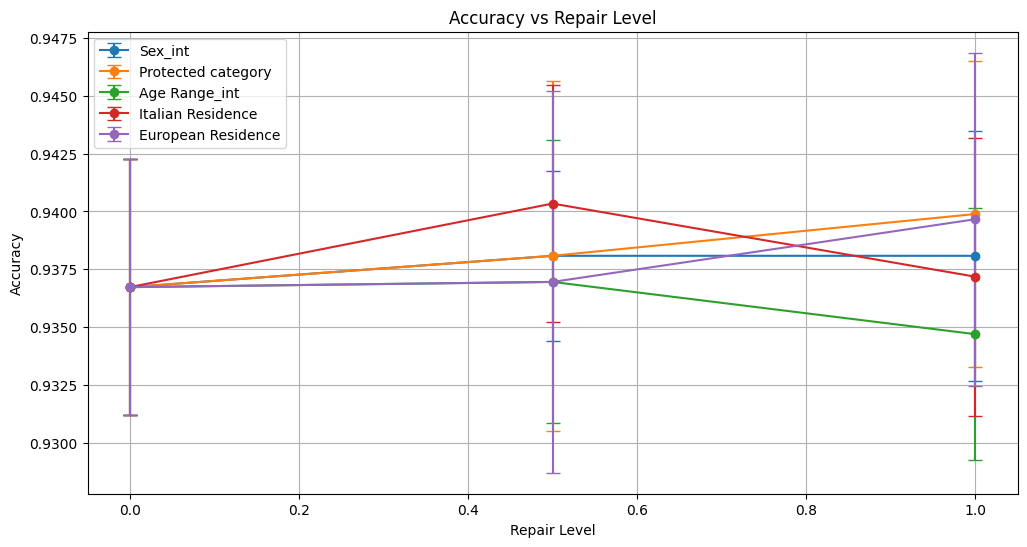

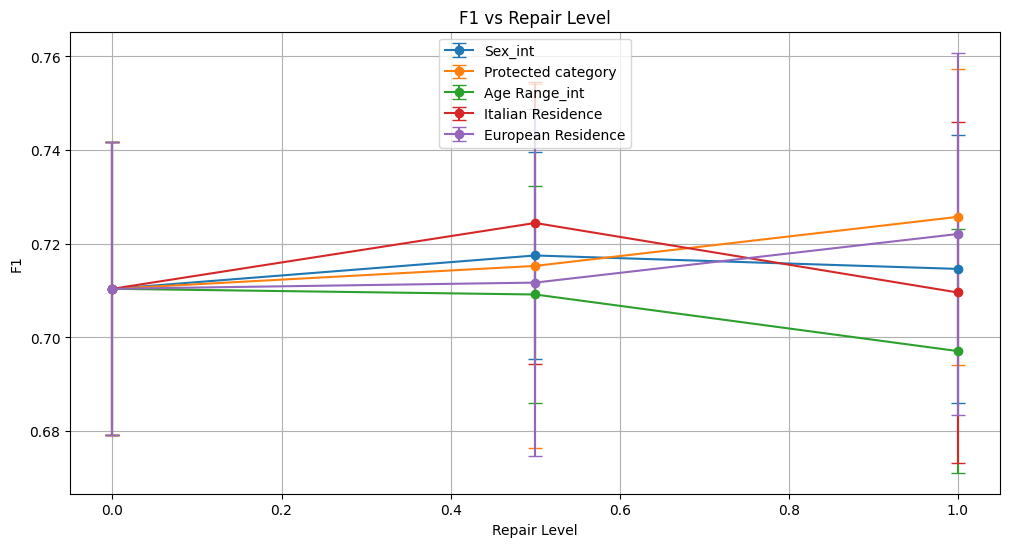

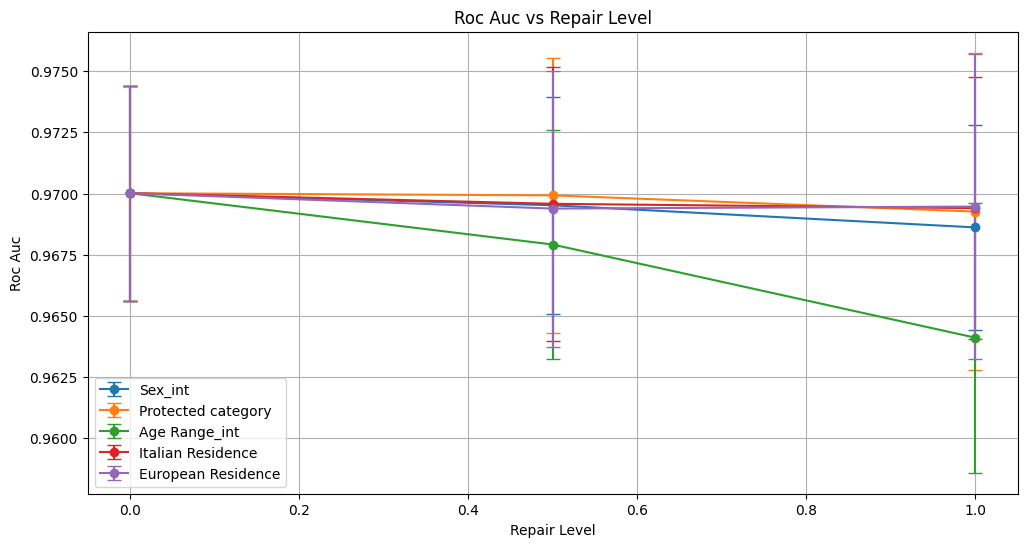

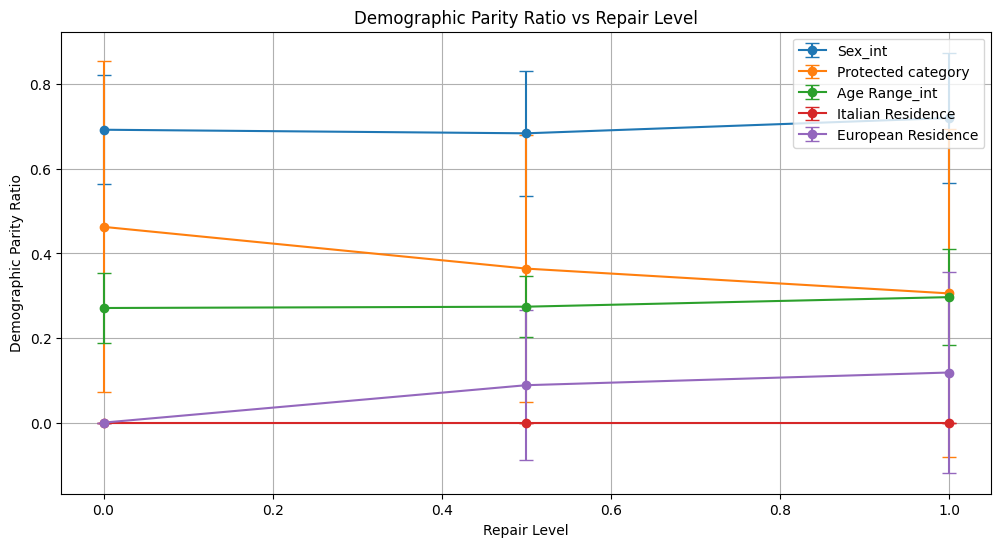

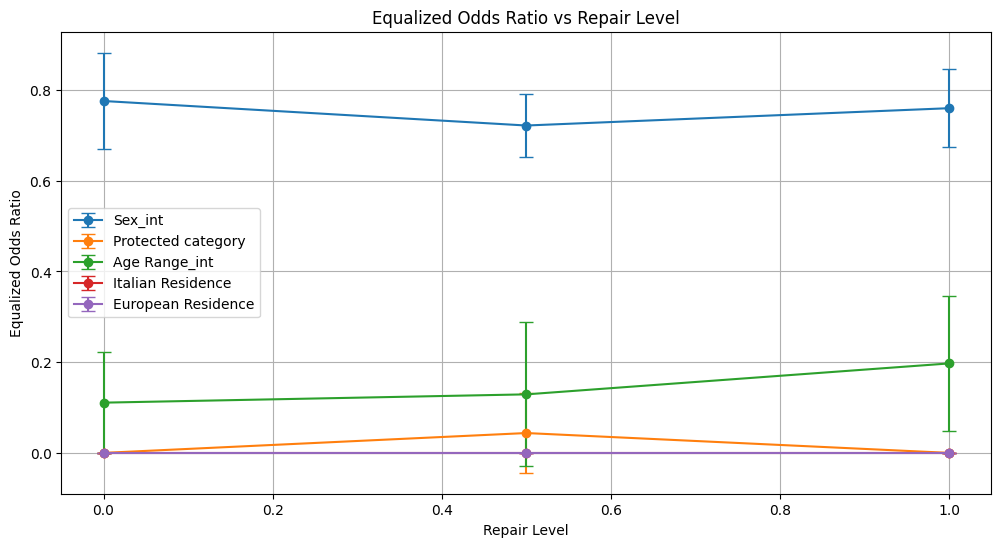

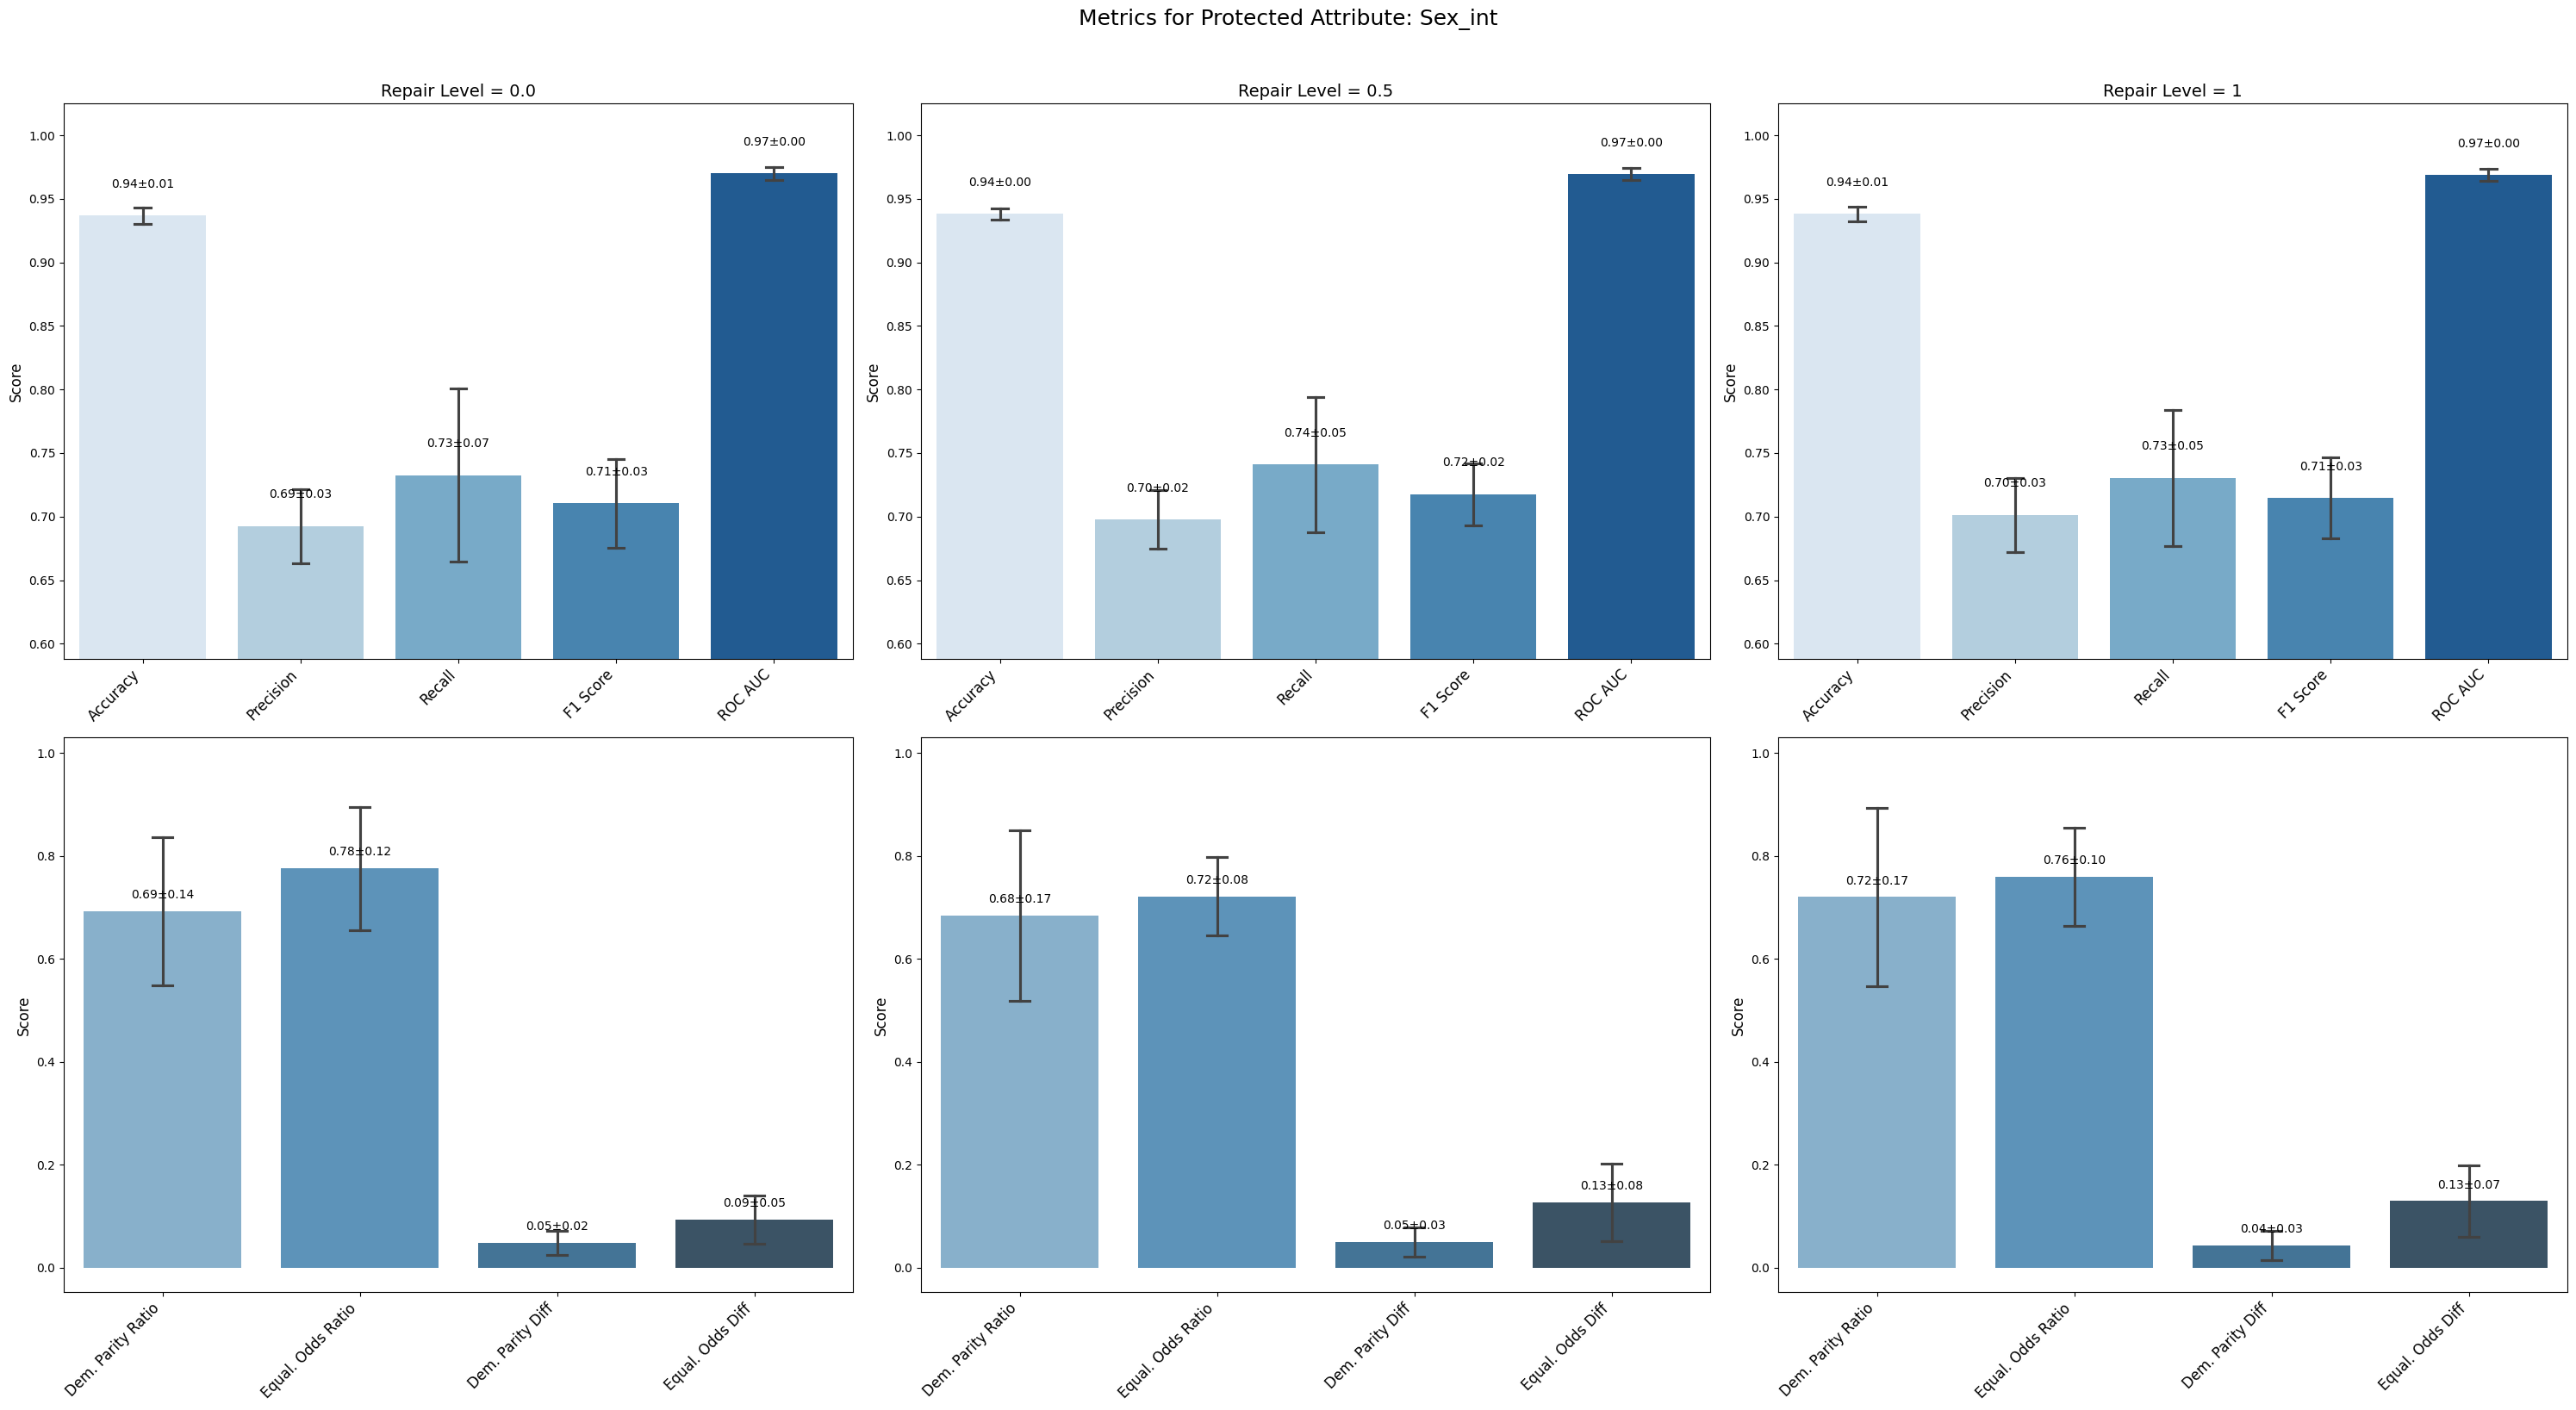

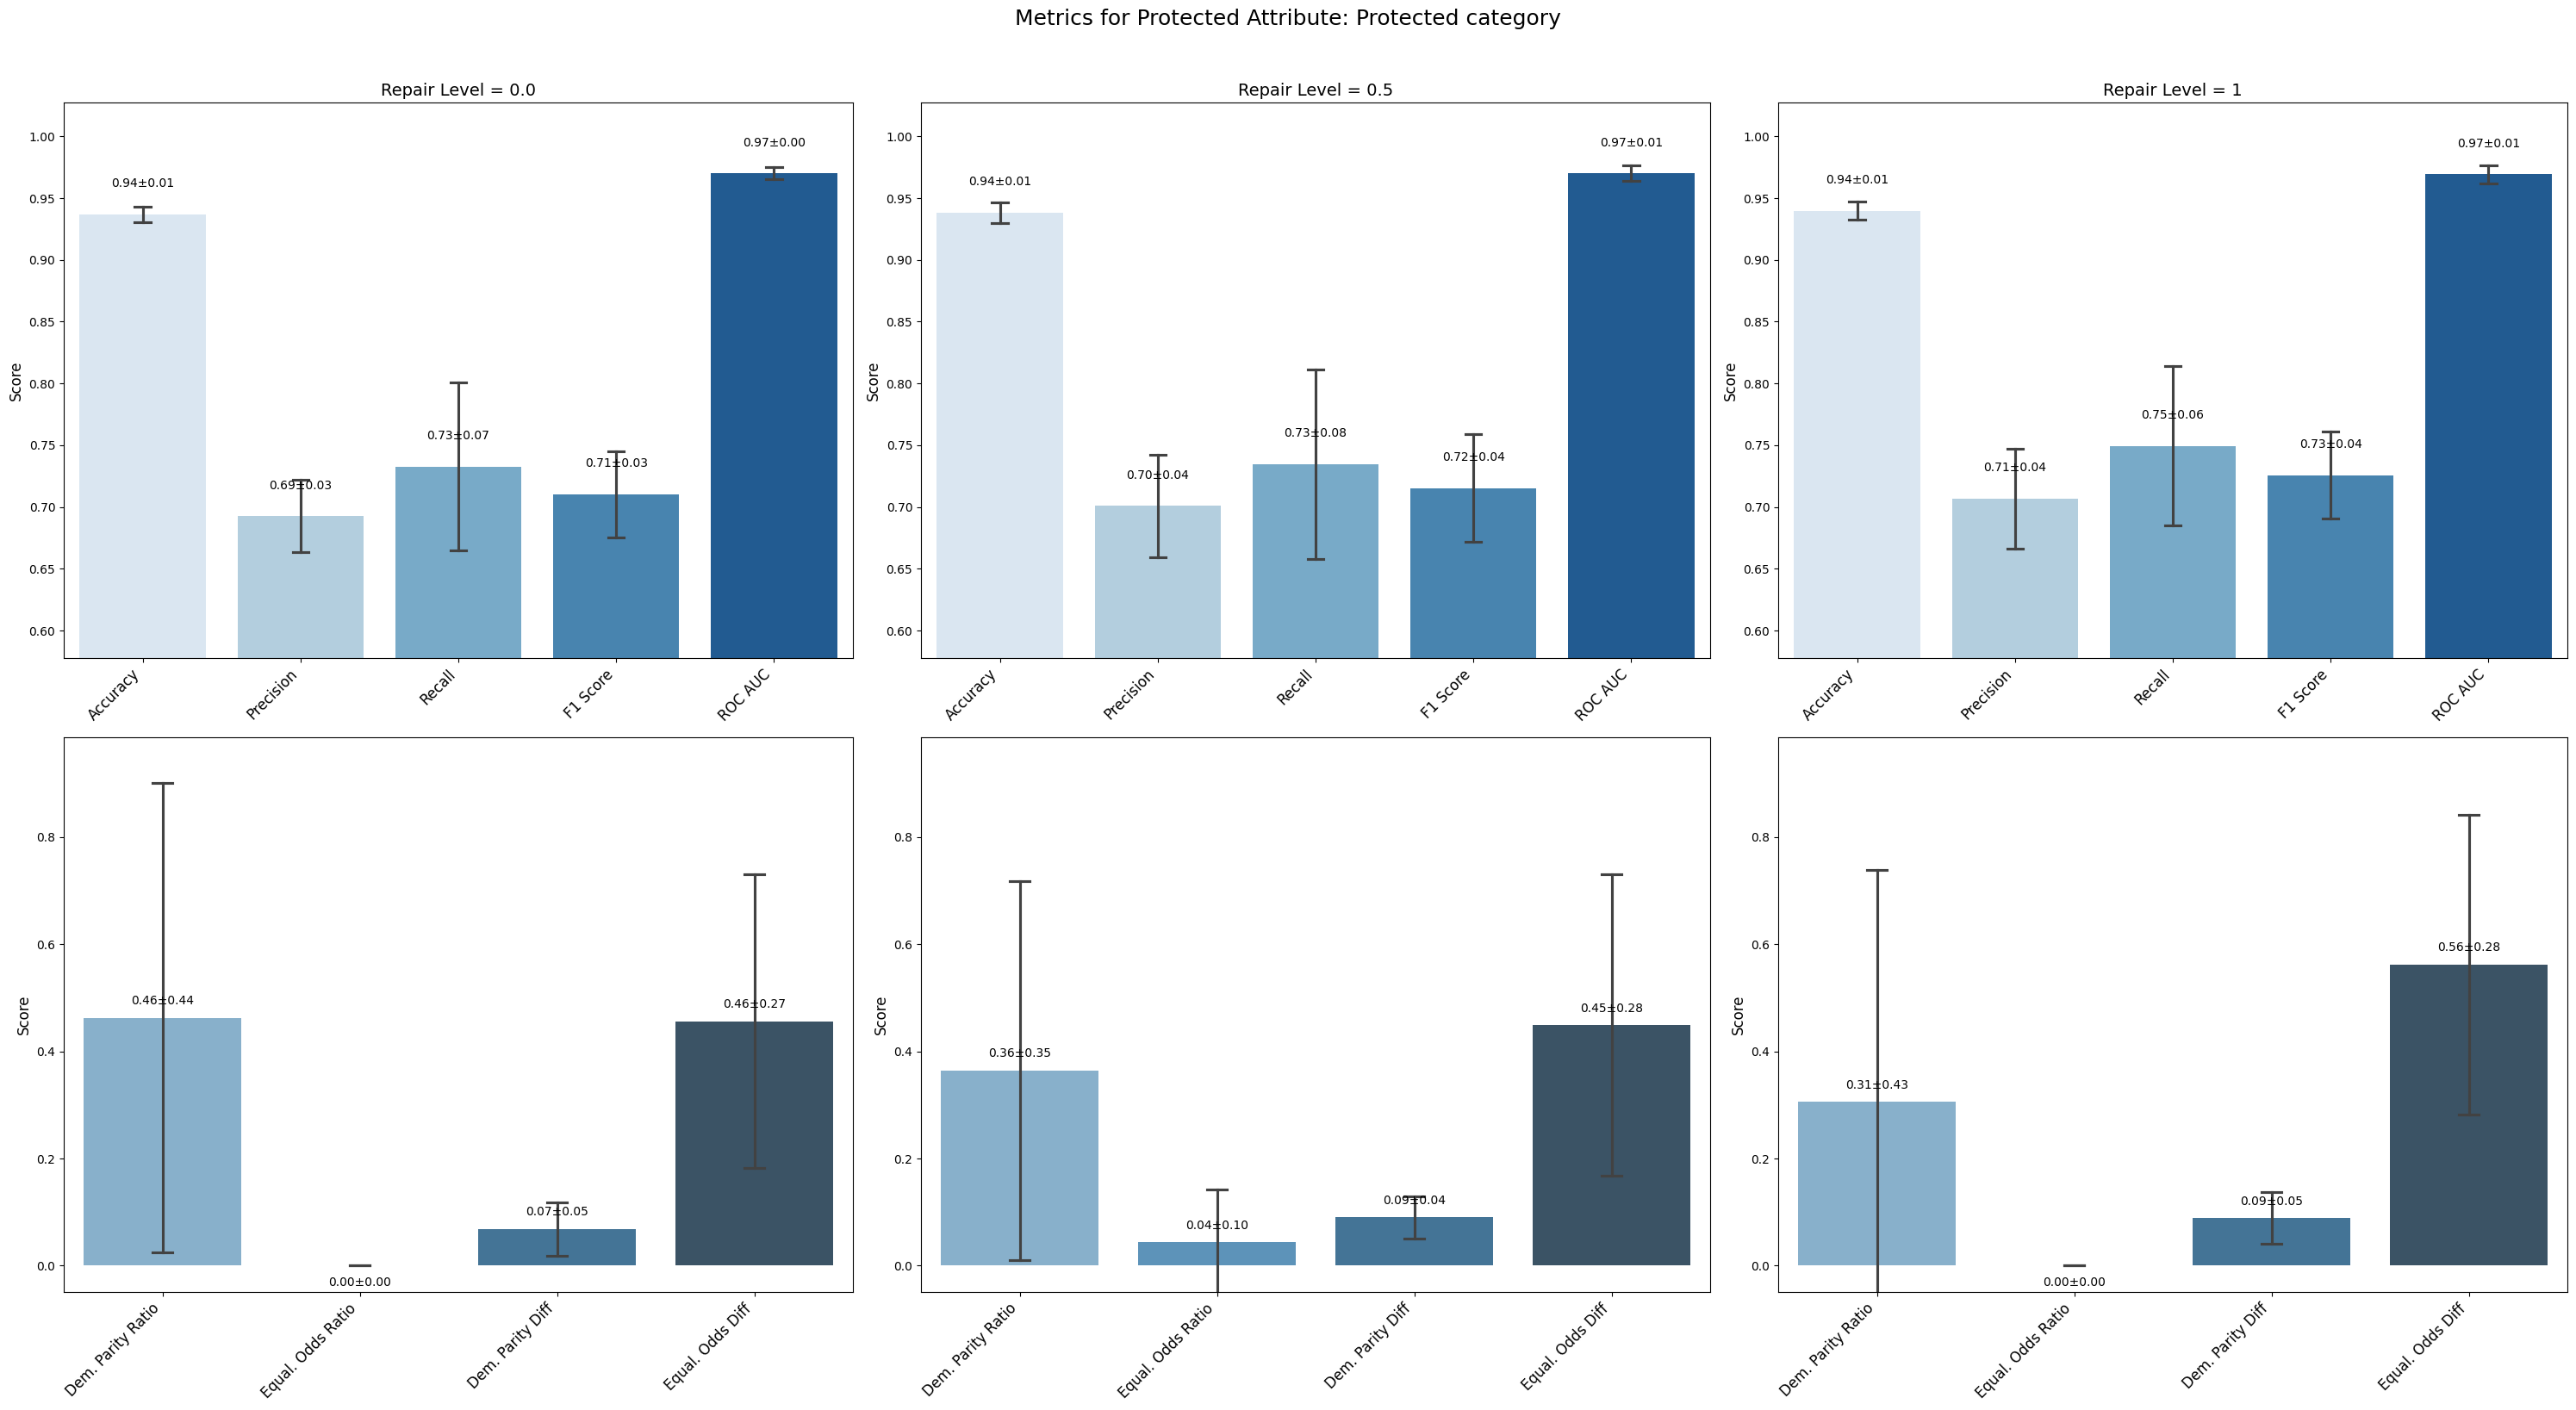

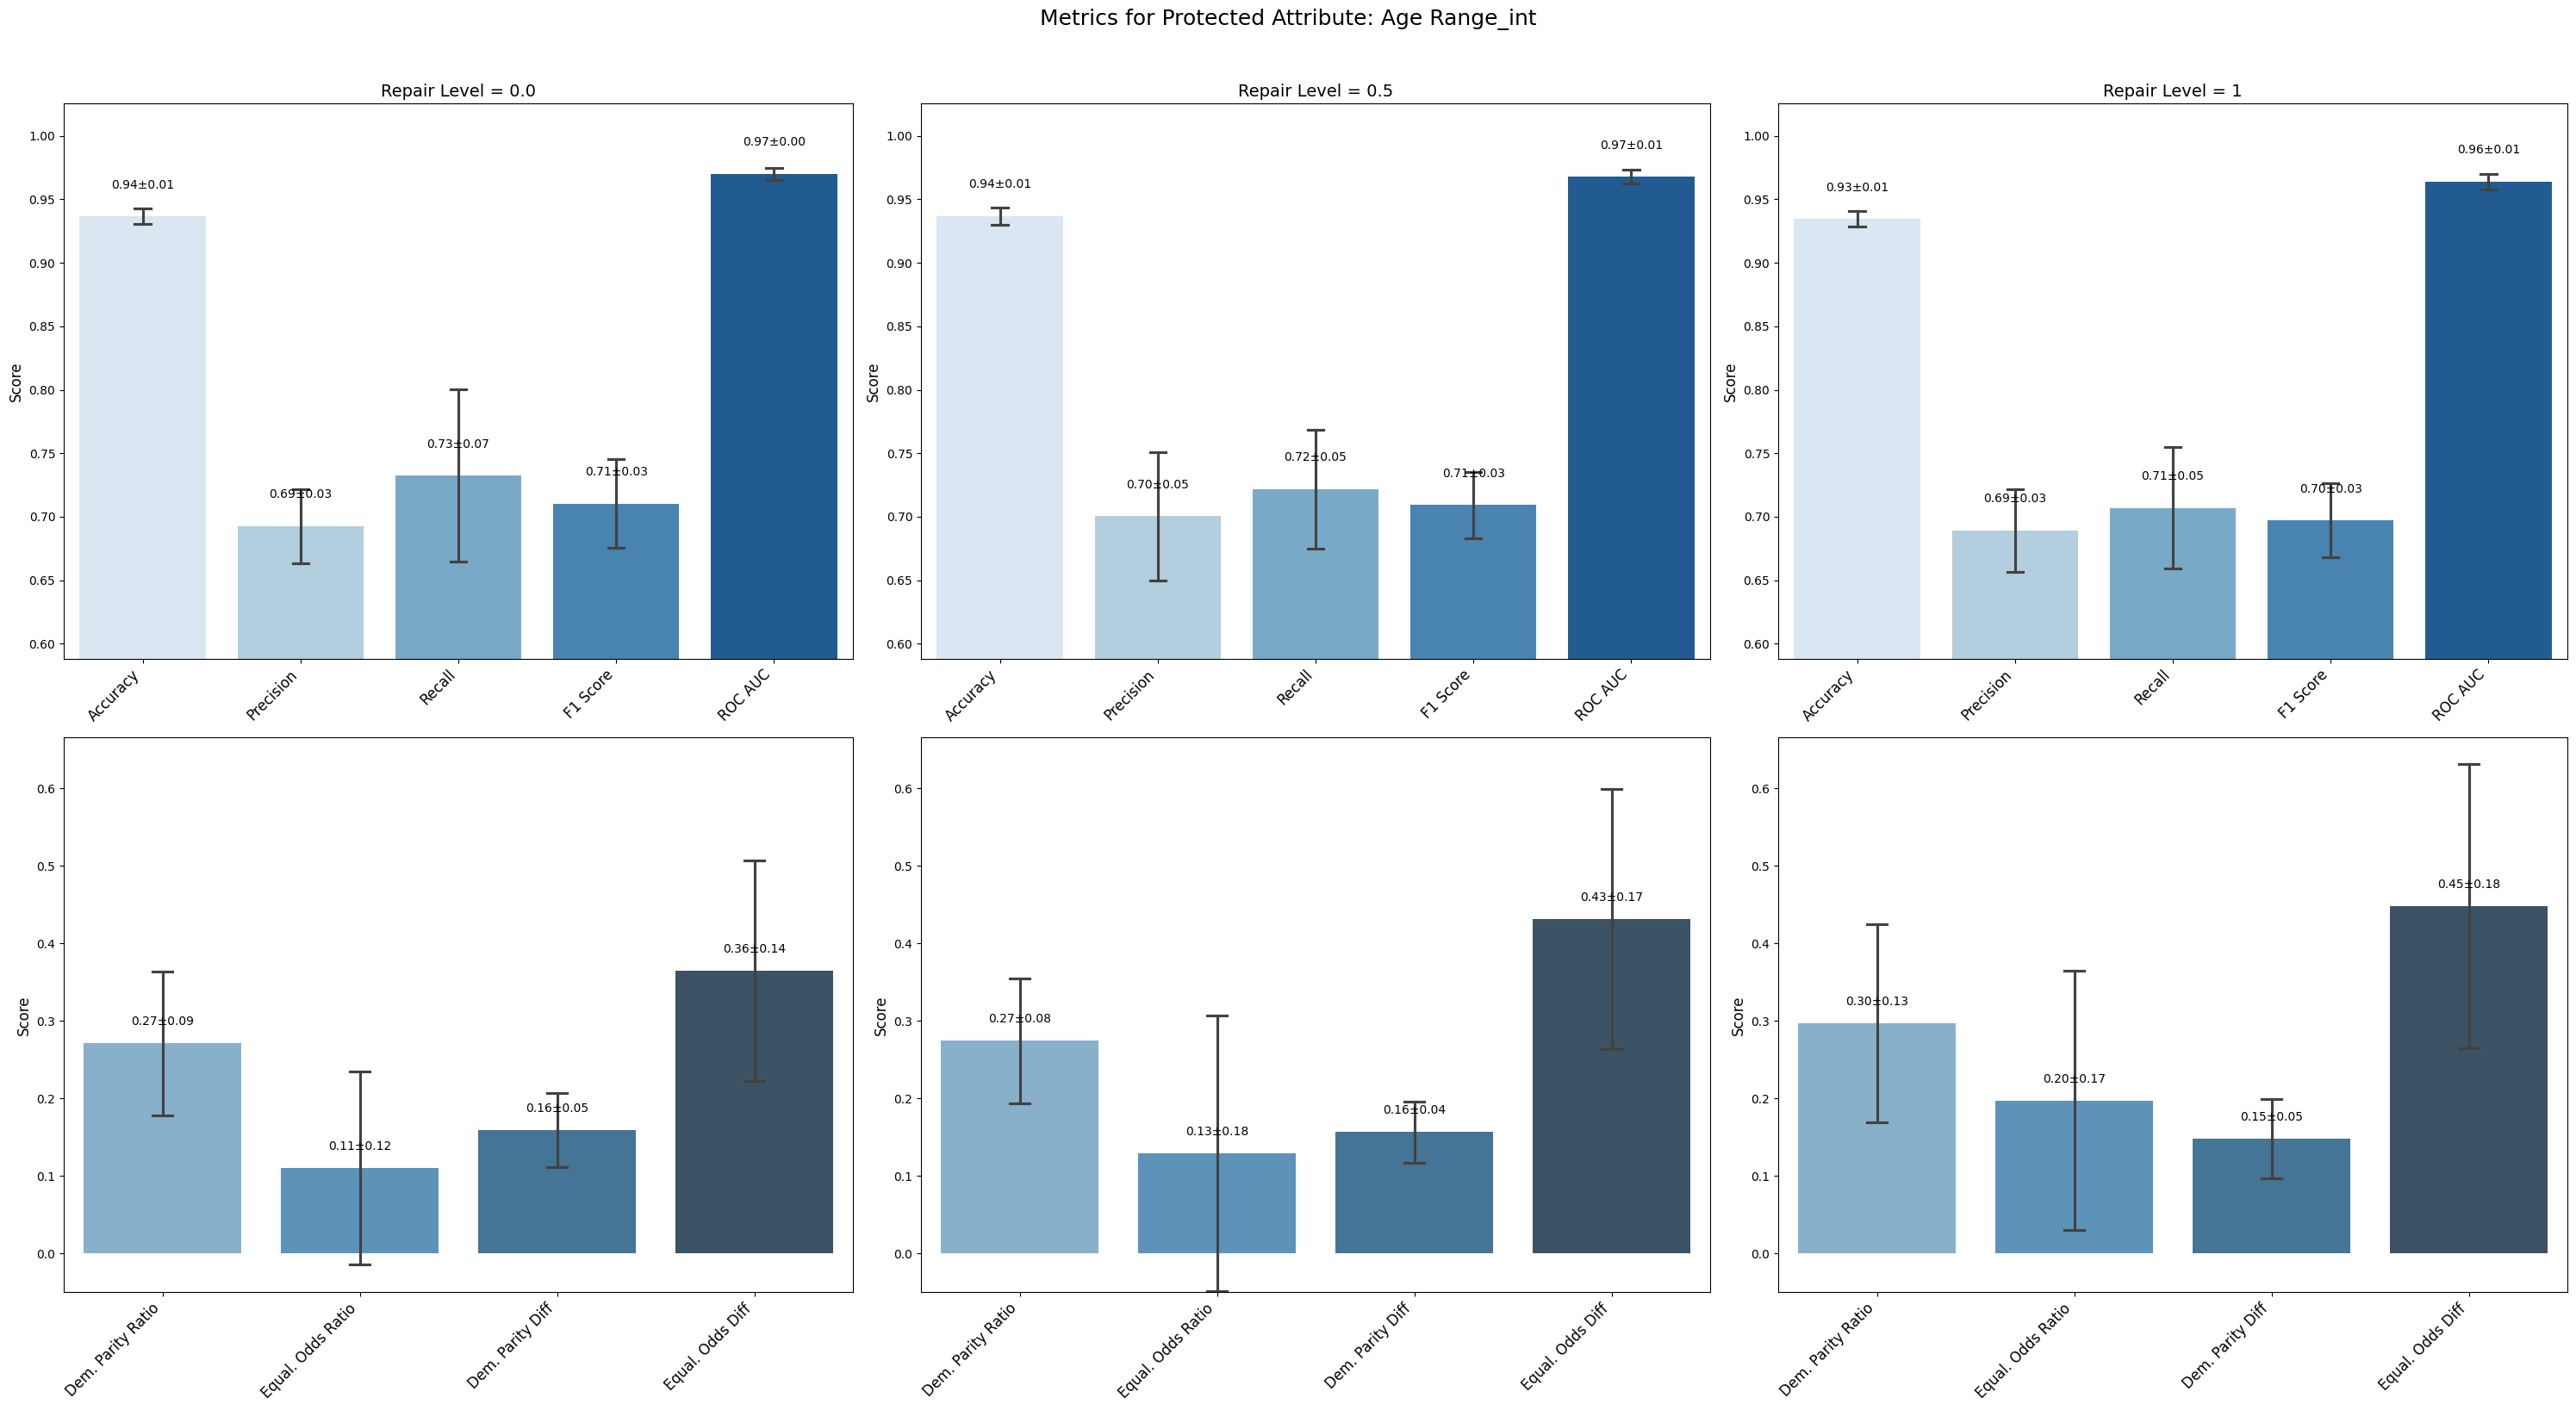

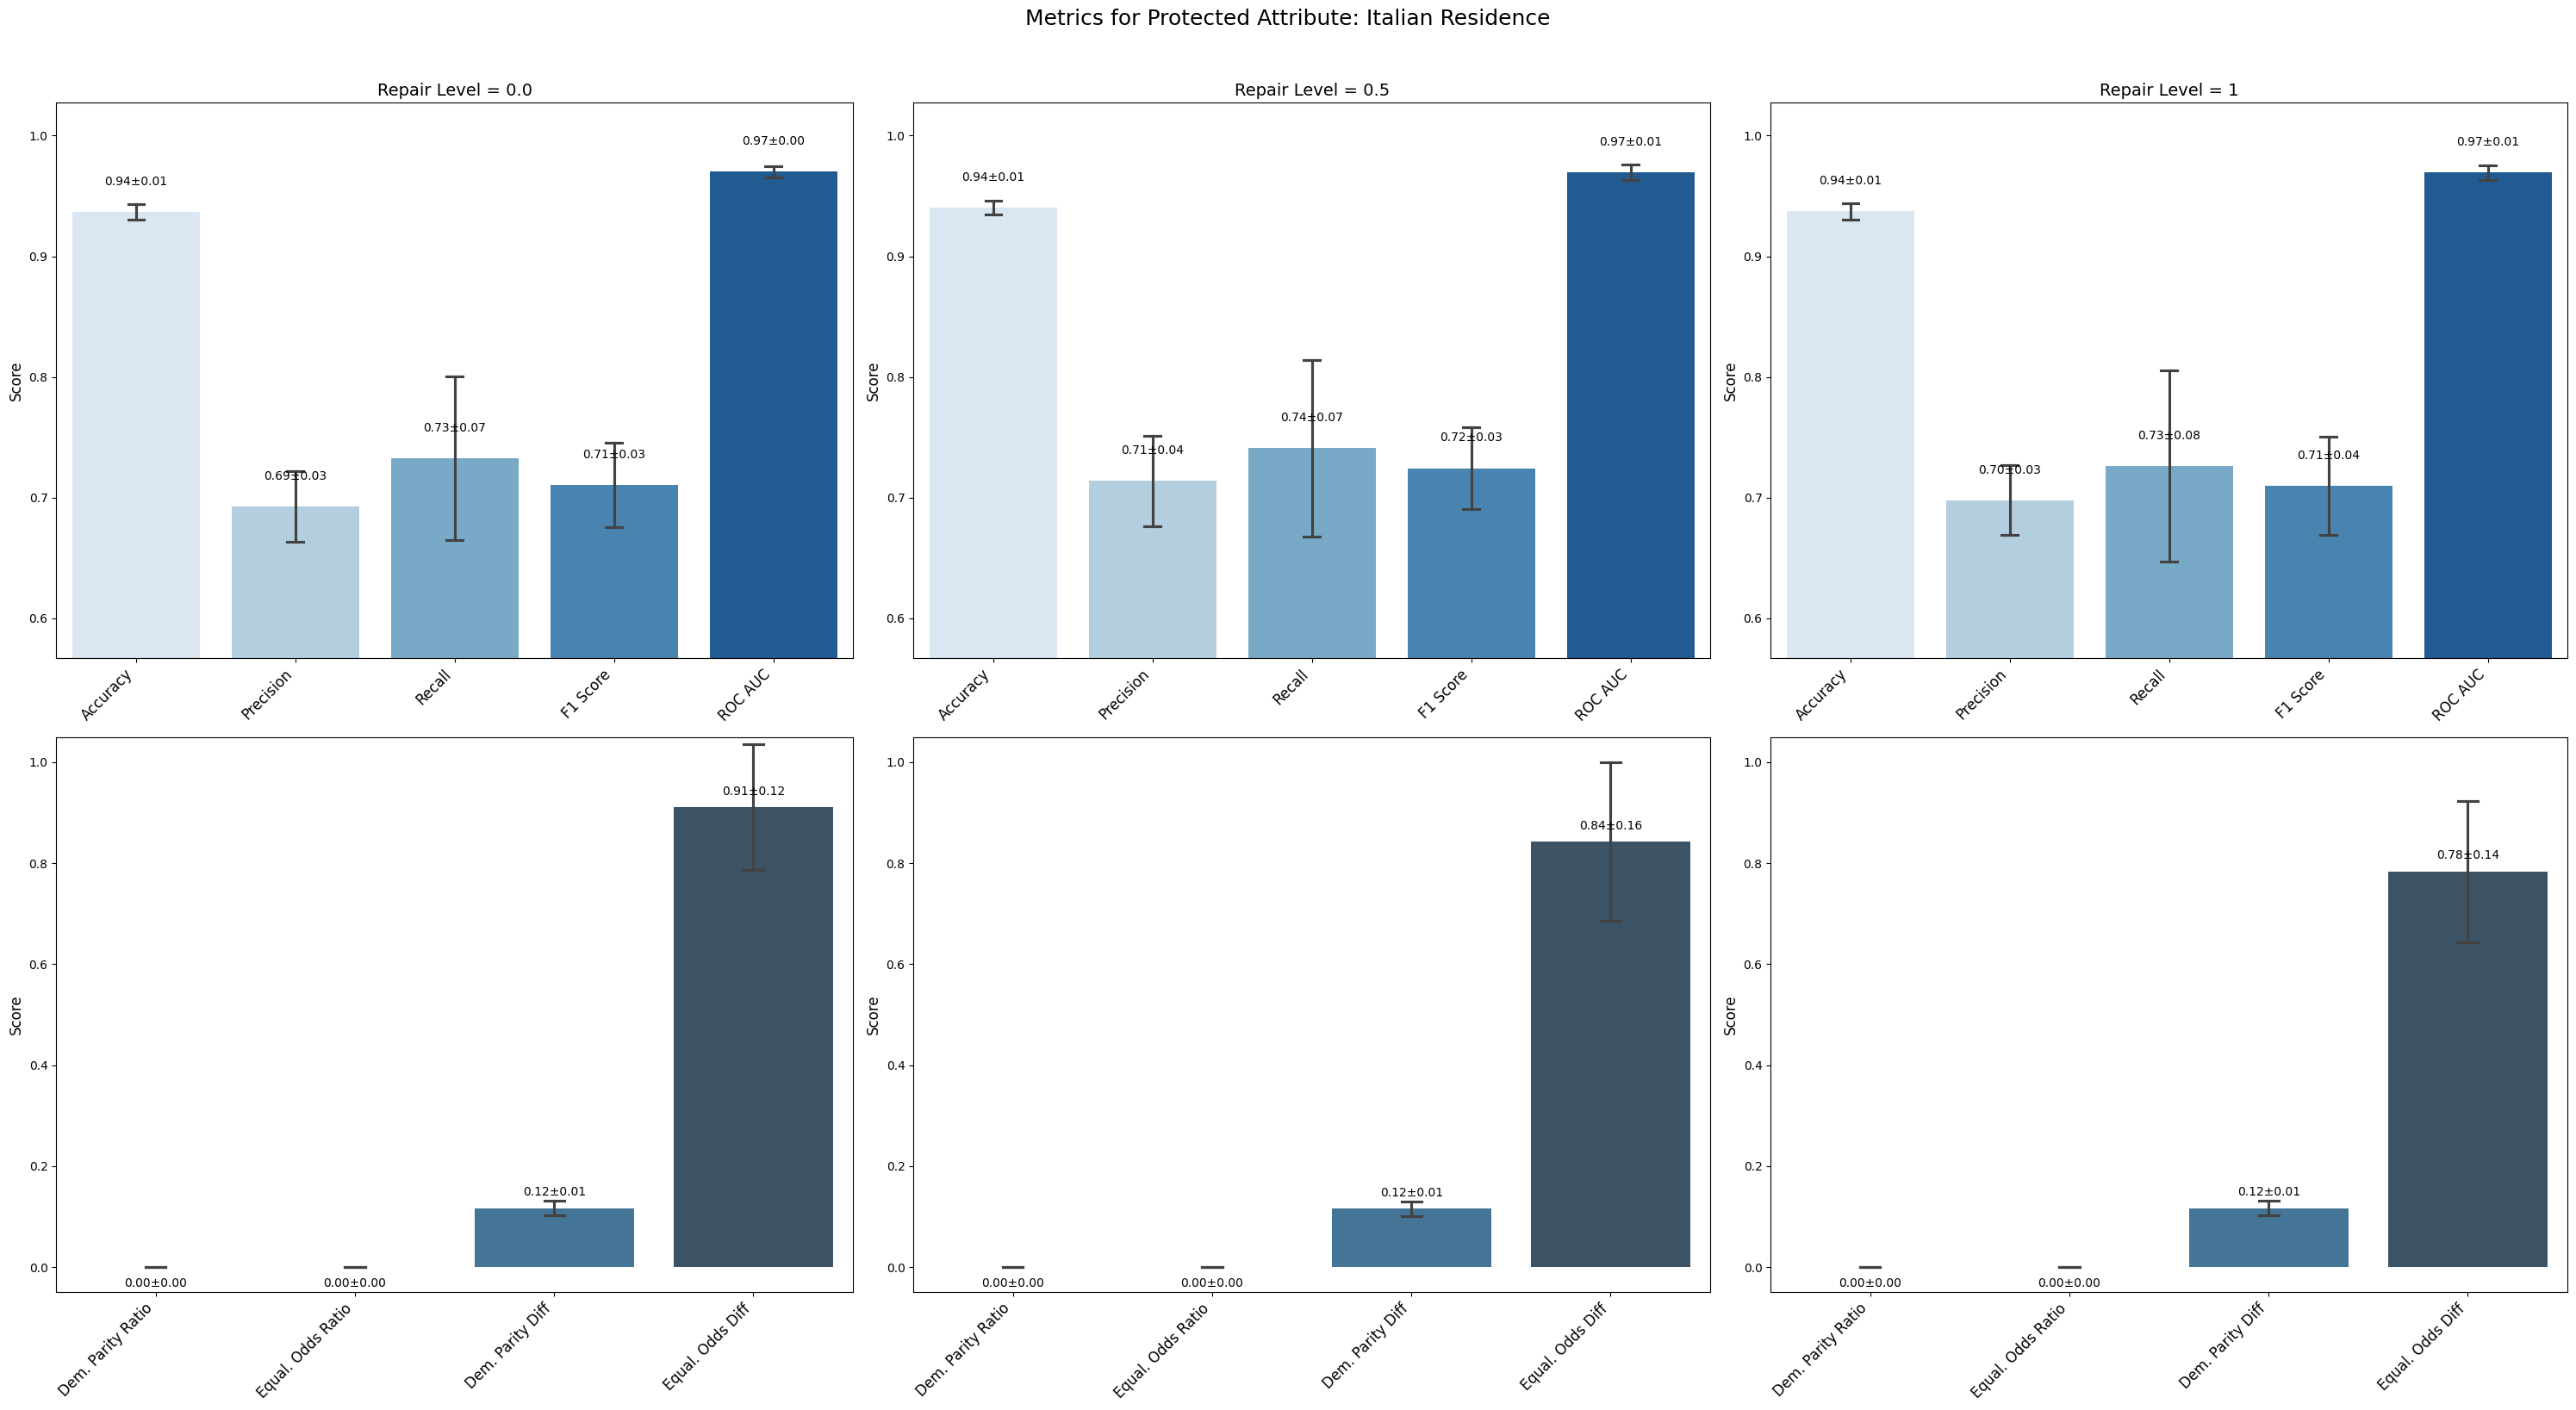

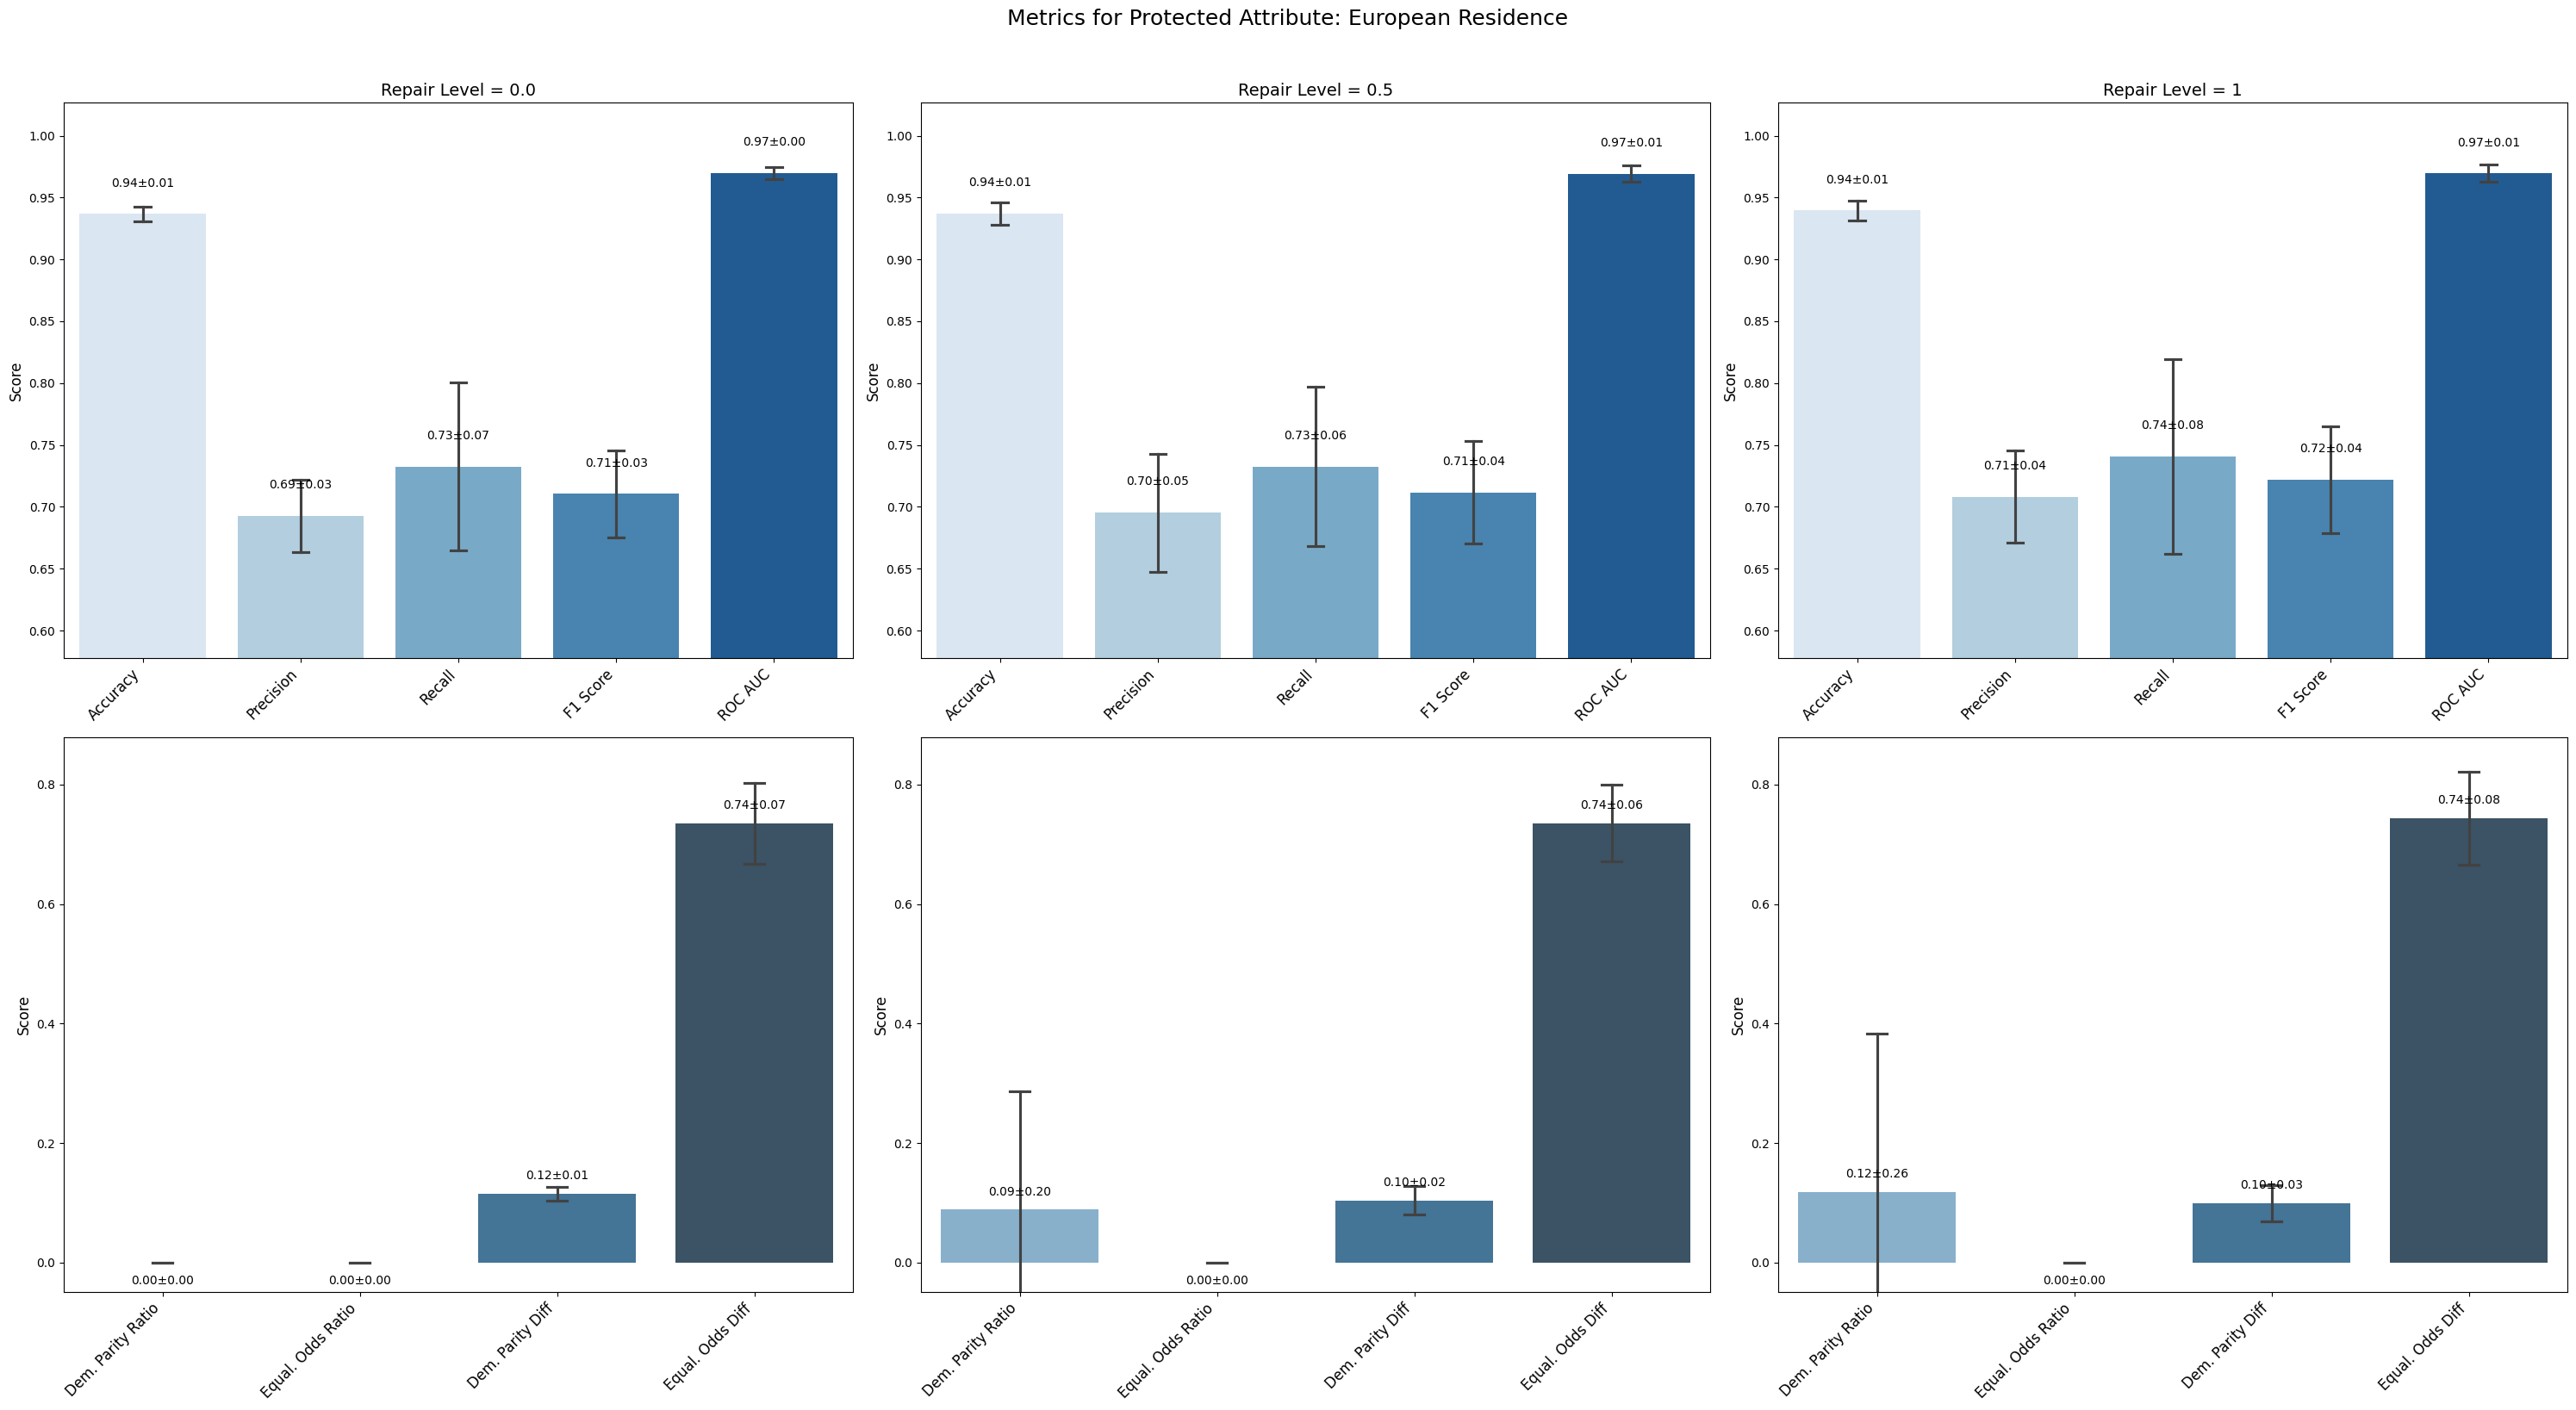

In [33]:
for metric in ['accuracy', 'f1', 'roc_auc', 'demographic_parity_ratio', 'equalized_odds_ratio']:
    plot_metrics(plot_data, metric, repair_levels, protected_attributes)

plot_metrics_grouped(results, protected_attributes, repair_levels)

## Reweighing

In [ ]:
results = defaultdict(list)
plot_data = defaultdict(dict)

n_folds = 5
repair_levels = [0, 1]

dataset = pd.DataFrame(df_cleaned[features + ["Hired"]])
bool_cols = dataset.select_dtypes(include="bool").columns
non_bool_cols = dataset[features].columns.difference(bool_cols)
dataset[bool_cols] = dataset[bool_cols].astype(int)

combined_protected_attributes = protected_attributes + ['all']

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in tqdm(
    enumerate(kf.split(dataset[features], dataset["Hired"]))
):
    train_df = dataset.iloc[train_idx]
    test_df = dataset.iloc[test_idx]

    imputer = SimpleImputer(strategy="mean")
    train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)
    test_df = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)

    scaler = StandardScaler()
    train_df[non_bool_cols] = scaler.fit_transform(train_df[non_bool_cols])
    test_df[non_bool_cols] = scaler.transform(test_df[non_bool_cols])
    
    for sensitive_attr in combined_protected_attributes:
        for repair_level in repair_levels:

            train_df_transformed = DataFrame(train_df.copy())
            test_df_transformed = DataFrame(test_df.copy())
            
            train_df_transformed.sensitive = protected_attributes if sensitive_attr=='all' else sensitive_attr
            train_df_transformed.targets = ['Hired']
     
            test_df_transformed.sensitive = protected_attributes if sensitive_attr=='all' else sensitive_attr
            test_df_transformed.targets = ['Hired']
            clf = HistGradientBoostingClassifier(random_state=random_state)
            if repair_level == 1:

                reweighing = ReweighingWithMean() if sensitive_attr=='all' else Reweighing()
                reweighed_df = reweighing.fit_transform(train_df_transformed)
                weights = reweighed_df['weights'].values
         
                clf.fit(train_df_transformed[features],train_df_transformed['Hired'], sample_weight=weights)
            else:
                clf.fit(train_df_transformed[features],train_df_transformed['Hired'])
                
            y_pred = clf.predict(test_df_transformed[features])
            y_prob = clf.predict_proba(test_df_transformed[features])[:, 1]
            y_test = test_df_transformed['Hired']
            X_test = test_df_transformed[features]

            metrics = {
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred, zero_division=0),
                "recall": recall_score(y_test, y_pred, zero_division=0),
                "f1": f1_score(y_test, y_pred, zero_division=0),
                "roc_auc": roc_auc_score(y_test, y_prob),
                "demographic_parity_ratio": demographic_parity_ratio(
                    y_test, y_pred, sensitive_features=X_test[protected_attributes if sensitive_attr=='all' else sensitive_attr]
                ),
                "equalized_odds_ratio": equalized_odds_ratio(
                    y_test, y_pred, sensitive_features=X_test[protected_attributes if sensitive_attr=='all' else sensitive_attr]
                ),
                "demographic_parity_difference": demographic_parity_difference(
                    y_test, y_pred, sensitive_features=X_test[protected_attributes if sensitive_attr=='all' else sensitive_attr]
                ),
                "equalized_odds_difference": equalized_odds_difference(
                    y_test, y_pred, sensitive_features=X_test[protected_attributes if sensitive_attr=='all' else sensitive_attr]
                ),
            }
            
            key = f"{sensitive_attr}_repair_{repair_level}"
            results[key].append(metrics)


metrics_keys = list(metrics.keys())
for sensitive_attr in combined_protected_attributes:
    for repair_level in repair_levels:
        key = f"{sensitive_attr}_repair_{repair_level}"
        fold_metrics = results.get(key, [])

        for metric in metrics_keys:
            metric_list = [m[metric] for m in fold_metrics]
            mean, std = get_mean_std(metric_list)
            plot_data[sensitive_attr][f"{metric}_mean_{repair_level}"] = mean
            plot_data[sensitive_attr][f"{metric}_std_{repair_level}"] = std

0it [00:00, ?it/s]

2it [00:24, 12.18s/it]

In [76]:
print_fairness_results_table(plot_data, metrics_keys, repair_levels)


=== Results for sensitive attribute: protected_attributes ===

                                Repair 0   Repair 1
accuracy                       nan ± nan  nan ± nan
precision                      nan ± nan  nan ± nan
recall                         nan ± nan  nan ± nan
f1                             nan ± nan  nan ± nan
roc_auc                        nan ± nan  nan ± nan
demographic_parity_ratio       nan ± nan  nan ± nan
equalized_odds_ratio           nan ± nan  nan ± nan
demographic_parity_difference  nan ± nan  nan ± nan
equalized_odds_difference      nan ± nan  nan ± nan


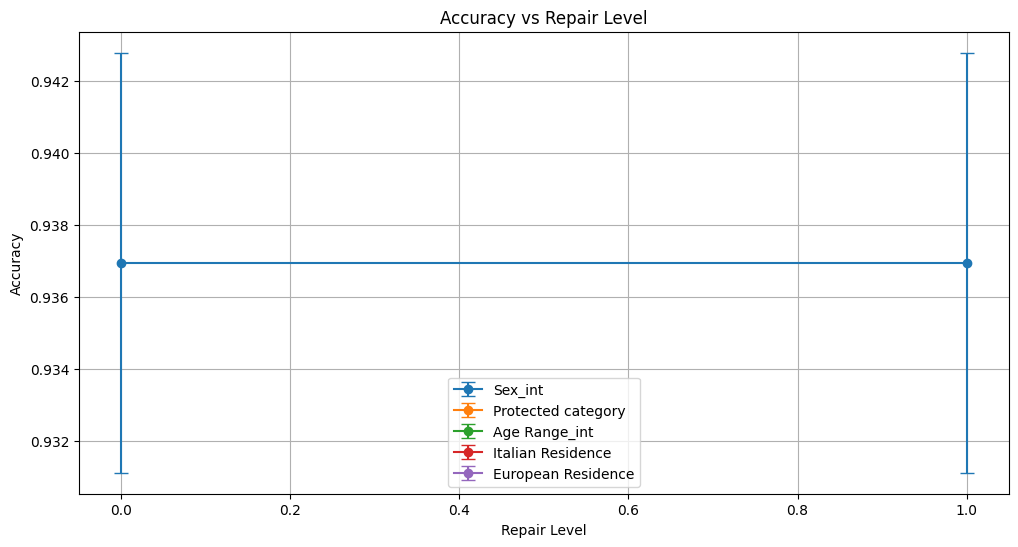

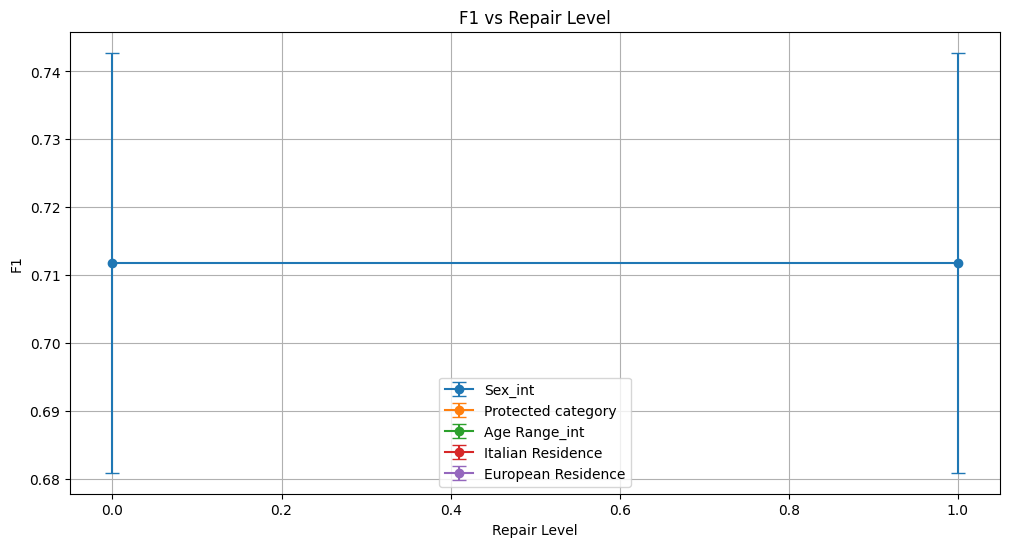

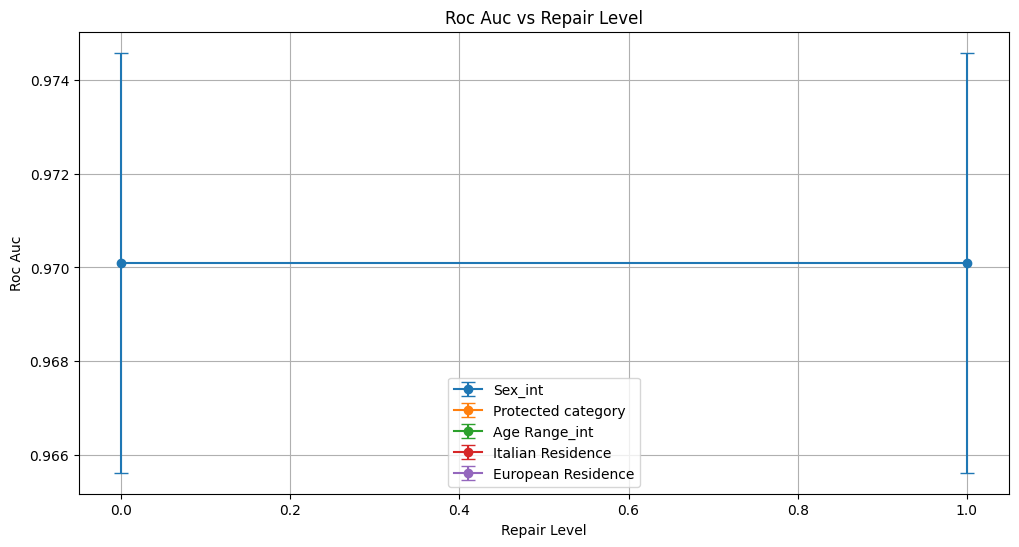

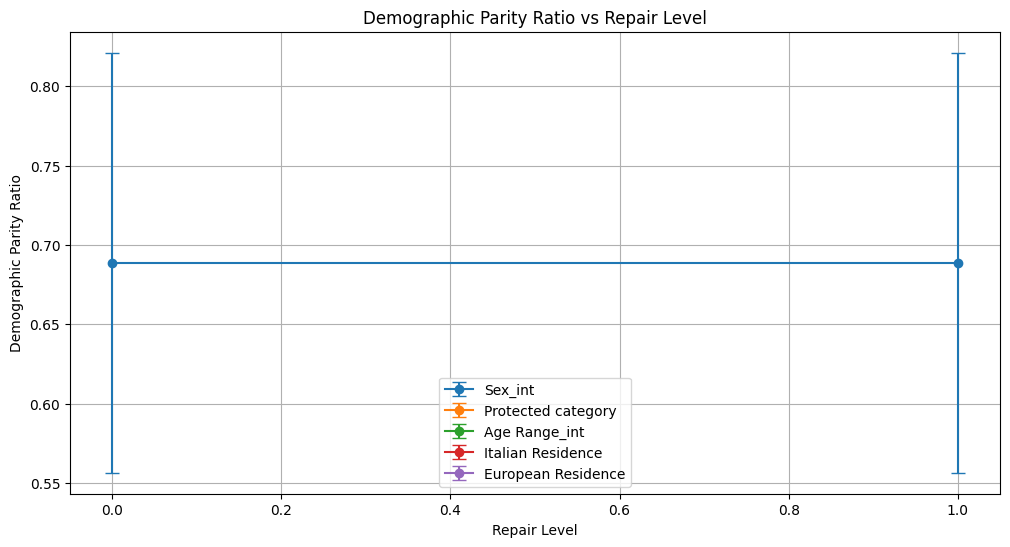

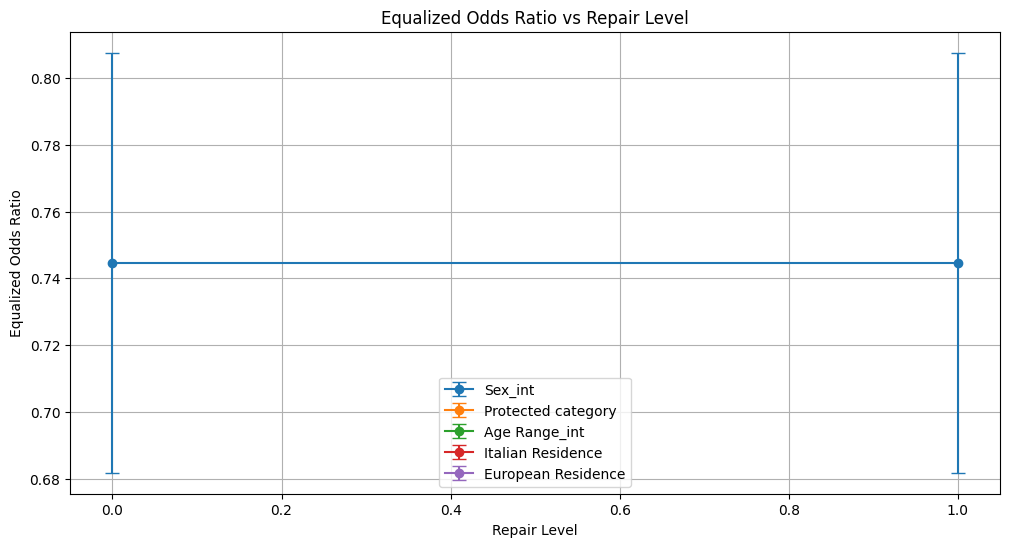

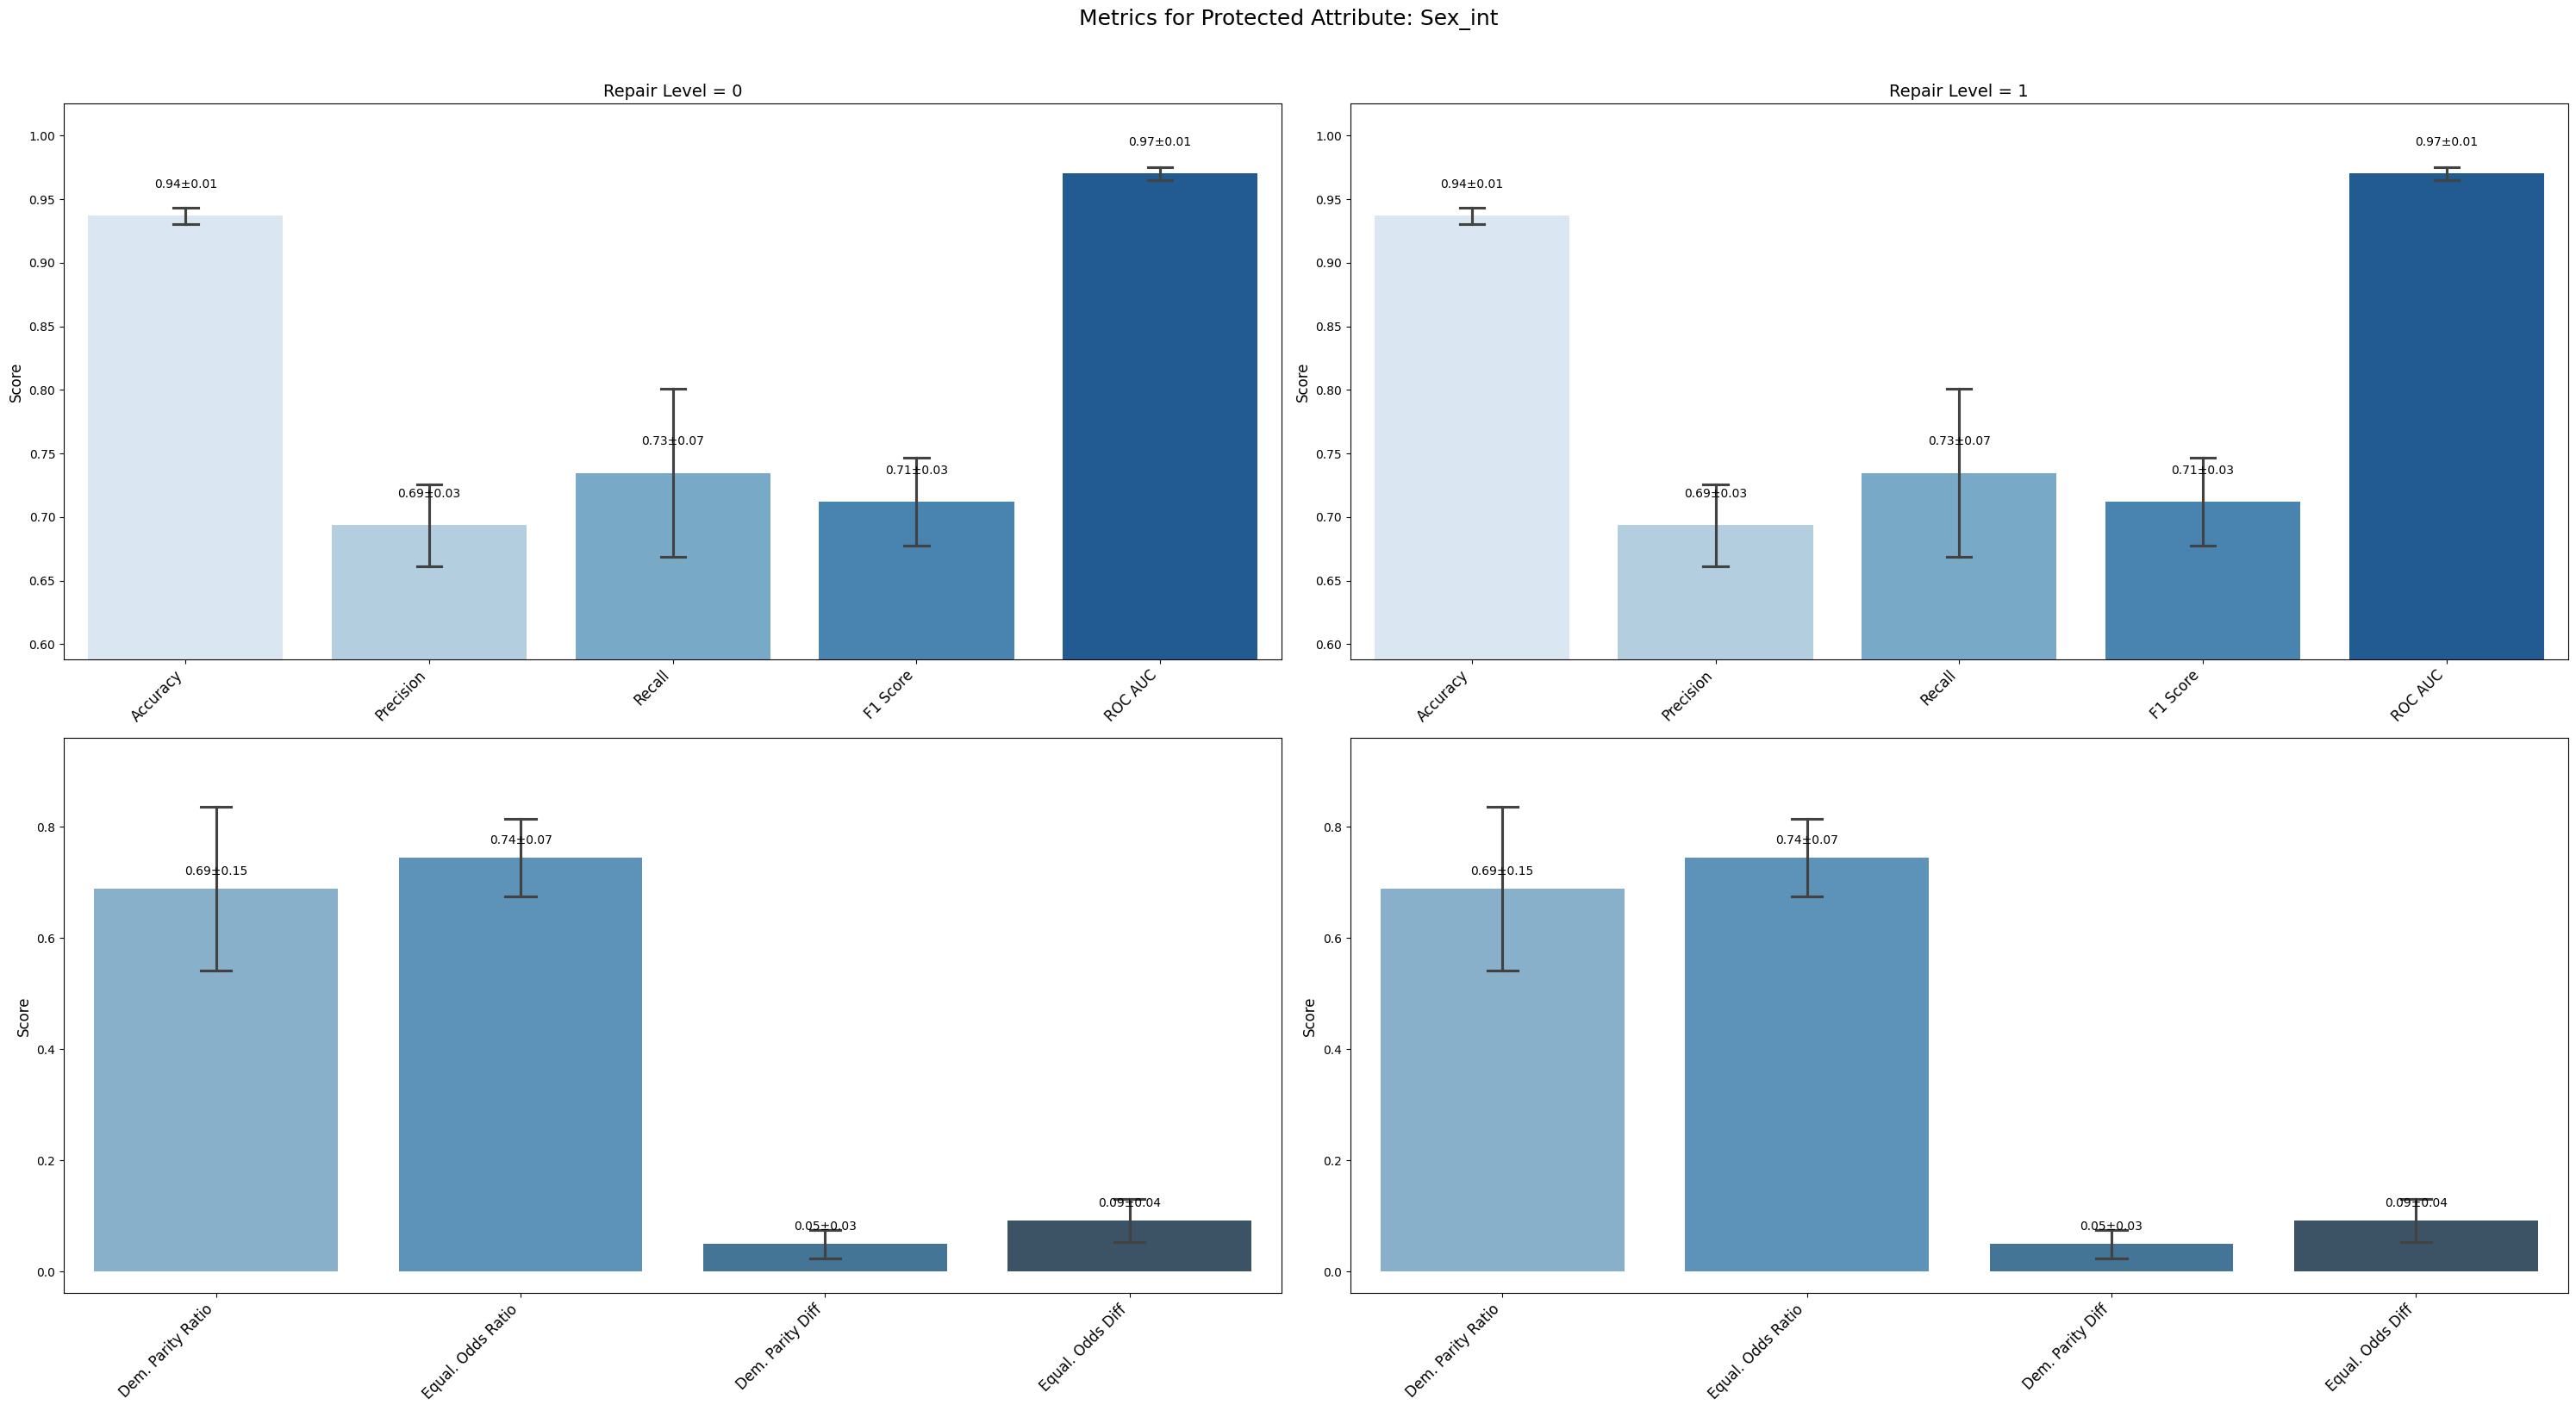

ValueError: Axis limits cannot be NaN or Inf

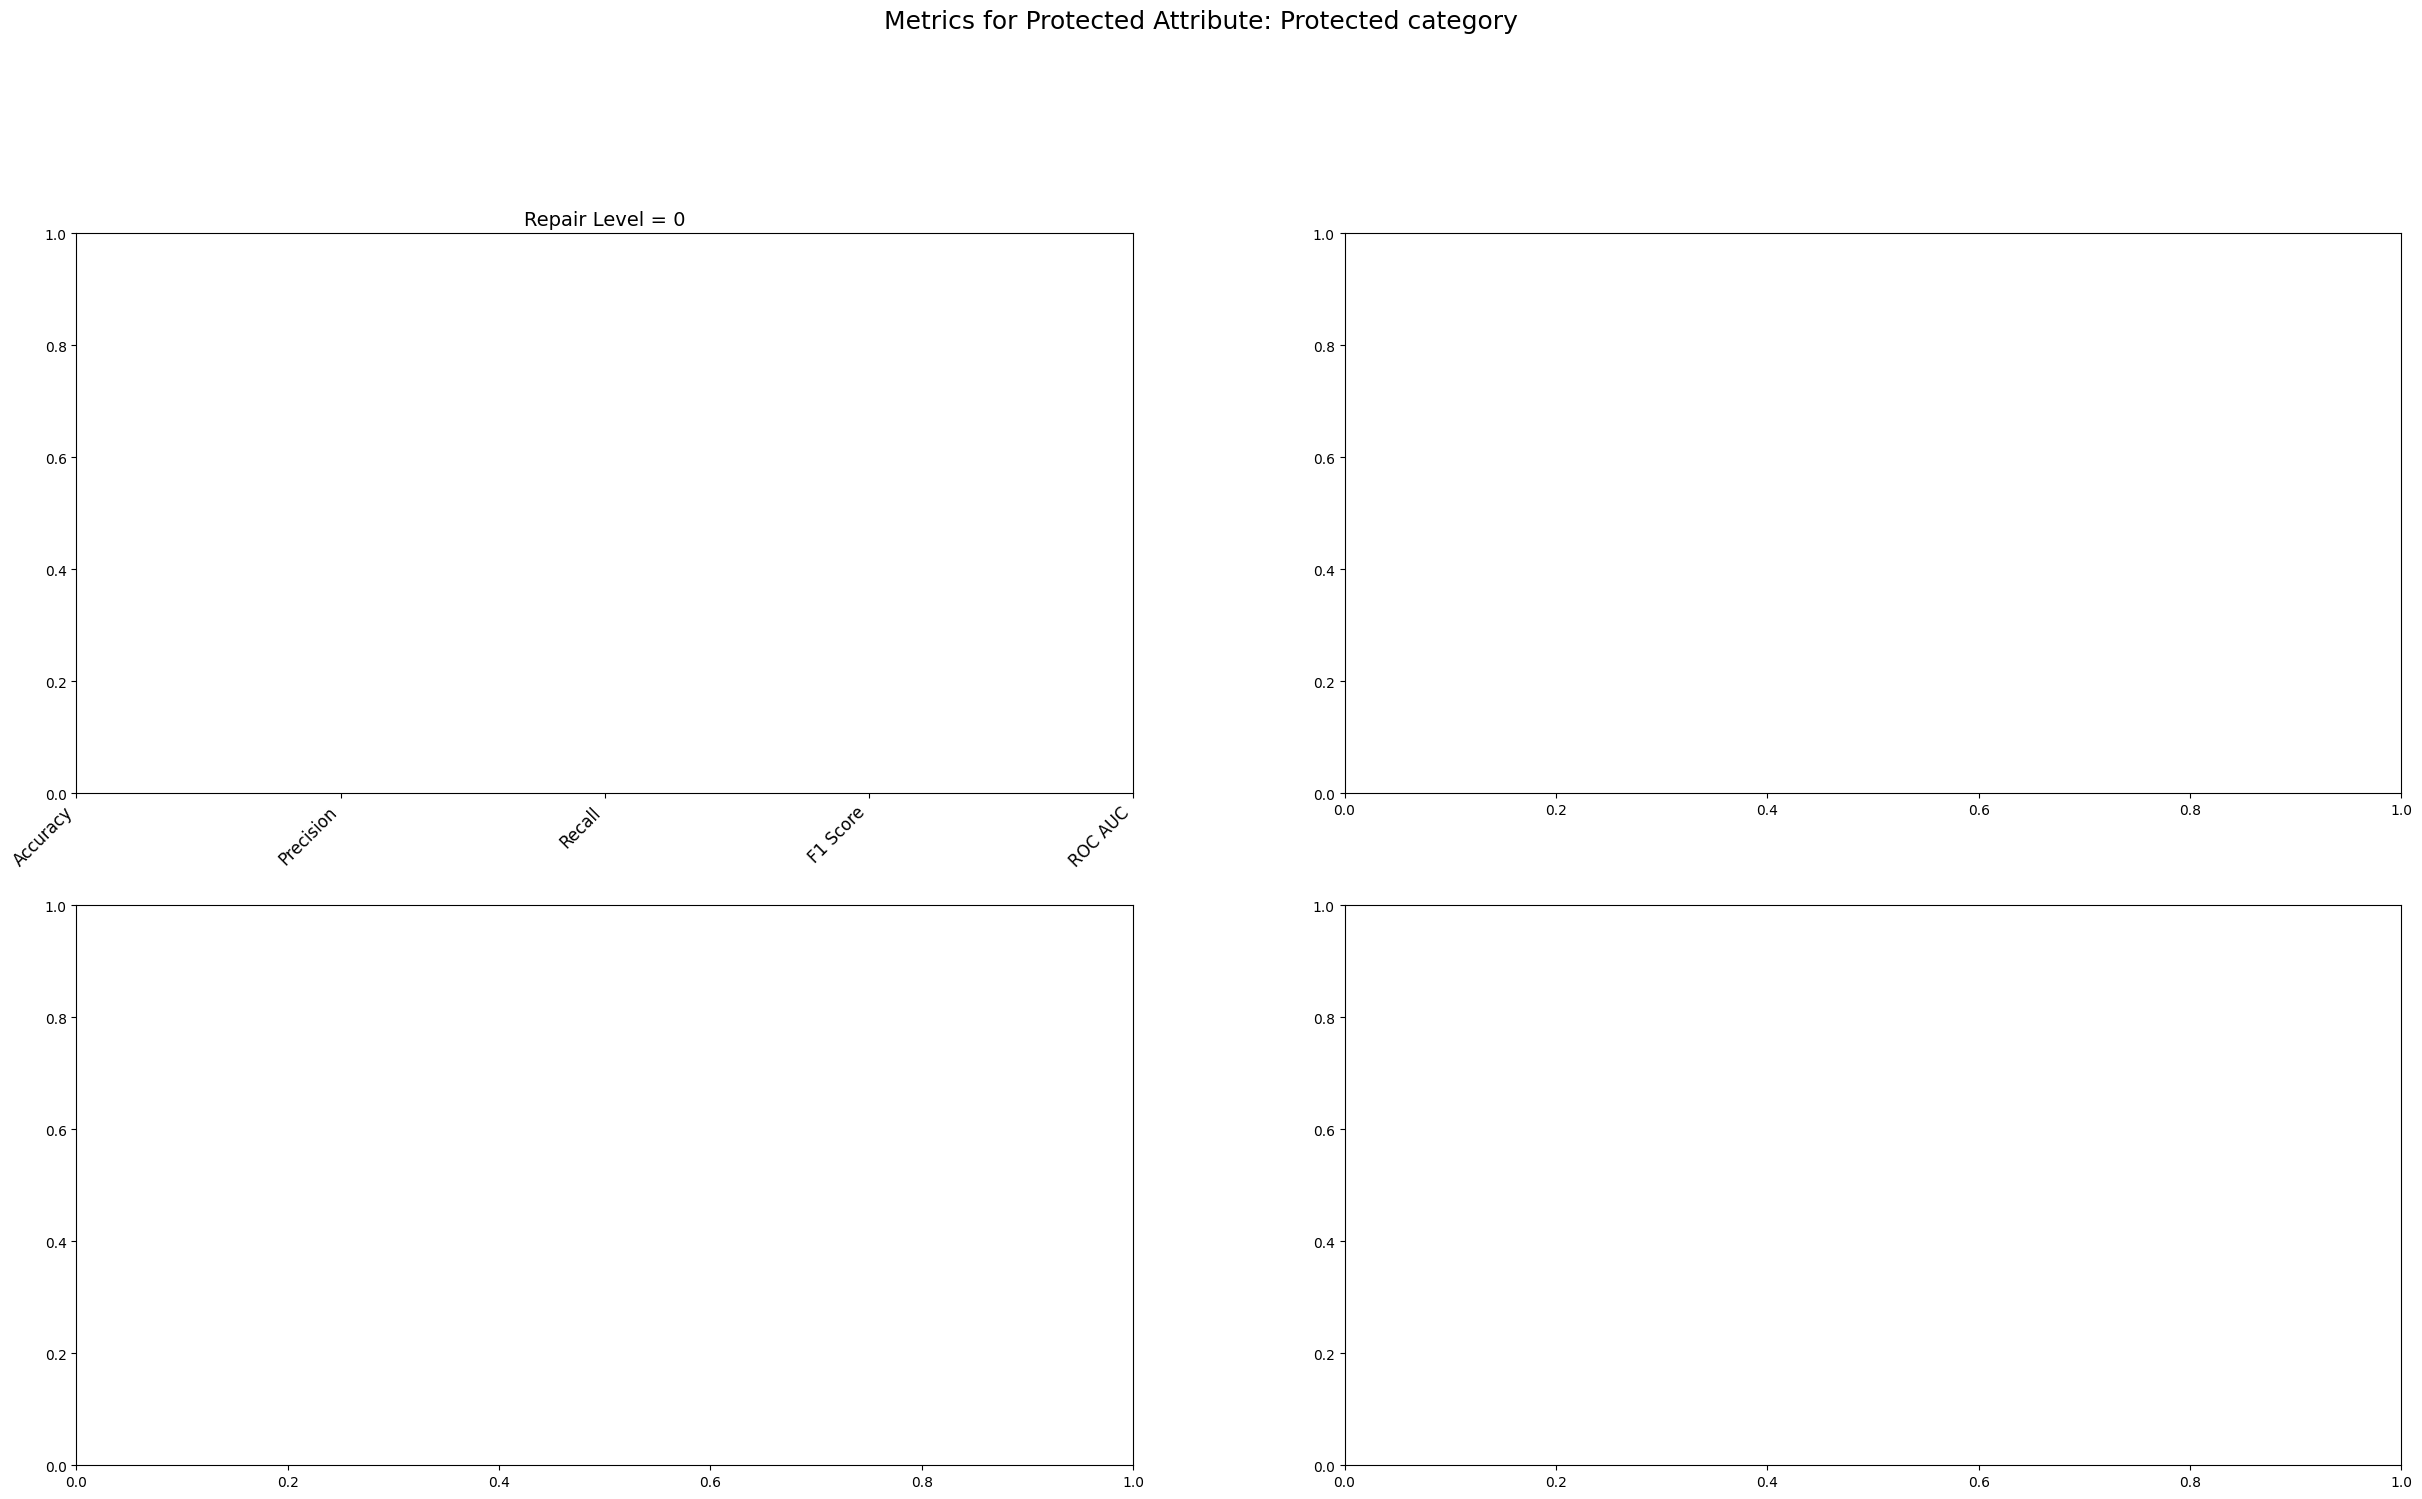

In [37]:
for metric in ['accuracy', 'f1', 'roc_auc', 'demographic_parity_ratio', 'equalized_odds_ratio']:
    plot_metrics(plot_data, metric, repair_levels, combined_protected_attributes)

plot_metrics_grouped(results, combined_protected_attributes, repair_levels)